In [51]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import spatial
import nevergrad as ng
from sklearn.decomposition import PCA
import json
from es.utils.visualize import label_point, draw_pts
from es.utils.DataProcessor import paramsDict2Array
# %matplotlib ipympl
# %matplotlib inline

In [52]:
# %matplotlib ipympl
# plt.rcParams["figure.figsize"] = (12, 8)
%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 15)

In [53]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

# Import Data

## set experiment parameters

In [54]:
# #  1, 2, 3, 5
# param_dict = {
#     0: 'speed',
#     1: 'max_curvature',
#     2: 'similarity',
#     3: 'follow_optim',
#     4: 'abs_speed_reward',
#     5: 'curvature_speed_punish',
#     6: 'opponent_collision'
# }
objective_dict = {0: 'progress', 1: 'agressive', 2:'safety'}
show_objective = {0, 1}

# 4
# param_dict = {
#     0: 'speed',
#     1: 'max_curvature',
#     2: 'length',
#     3: 'similarity',
#     4: 'follow_optim',
#     5: 'abs_speed_reward',
#     6: 'curvature_speed_punish',
#     7: 'opponent_collision'
# }
#
# # v2
# param_dict = {
#     0: 'speed',
#     1: 'max_curvature',
#     2: 'length',
#     3: 'similarity',
#     4: 'follow_optim',
#     5: 'abs_speed_reward',
#     6: 'curvature_speed_punish',
#     7: 'opponent_collision',
#     8: 'collision thres'
# }

In [55]:
# tmp, after the param_dict is stored in the config
param_dict = {
    0: 'speed',
    1: 'max_curvature',
    2: 'length',
    3: 'similarity',
    4: 'follow_optim',
    5: 'abs_speed_reward',
    6: 'curvature_speed_punish',
    7: 'opponent_collision',
    8: 'collision thres'
}
param_name_list = [
    "traj_v_scale",
    "cost_weights",
    "collision_thres"
  ]

## set run/epoch

In [ ]:
# data_module = os.path.abspath('../data')
store_dir = 'data'
# store_dir = 'es_model'
inside = False
if inside:
    data_module = os.path.abspath('..')
else:
    data_module = os.path.abspath(f'../{store_dir}')
    
run = 31
epoch = 120
budget = 19200
worker_num = 100
objective_num = 2
scene_num = 120

if store_dir=='es_model':
    score_file = f'{run}/default_CMA_budget_{budget}epoch{epoch}_score.npz'
    optimpkl_file = f'{run}/default_CMA_budget_{budget}epoch{epoch}_optim.pkl'
    oppo_file = f'{run}/default_CMA_budget_{budget}_opp_weights.npz'
else:
    score_file = f'{run}/scores/default_CMA_budget_{budget}epoch{epoch}_score.npz'
    optimpkl_file = f'{run}/optims_pkl/default_CMA_budget_{budget}epoch{epoch}_optim.pkl'
    oppo_file = f'{run}/scores/default_CMA_budget_{budget}_opp_weights.npz'
scenario_file = f'{run}/rollout_scenarios.npz'
config_file = f'{run}/config.json'

font_size = 30
# plt.rcParams["figure.figsize"] = (30, 15)

## load files

In [ ]:
score_data = np.load(os.path.join(data_module, score_file), mmap_mode='r', allow_pickle=True)
all_scores = score_data['scores']
params_obj = score_data['params']
config_data = json.load(open(os.path.join(data_module, config_file)))
oppo_data = np.load(os.path.join(data_module, oppo_file), mmap_mode='r')
try:
    scenario_data = np.load(os.path.join(data_module, scenario_file), mmap_mode='r', allow_pickle=True)
except:
    pass
opp_weights = oppo_data['opp_weights']

# all_seeds = []
# for i in range(len(scores)):
#     all_seeds.append(params_obj[i].value)
all_seeds = params_obj
all_seeds = np.array(all_seeds).T
all_scores = all_scores.T

try:
    param_dict = config_data['params_dict']
    param_name_list = config_data['params_name']
    print('load param dict from config')
except:
    pass
print(param_name_list)

In [ ]:
print(config_data)

In [ ]:
print(all_scores.shape)
print(all_seeds.shape)

In [ ]:
optim_path = os.path.join(data_module, optimpkl_file)
optim = ng.optimizers.base.Optimizer.load(optim_path)

# show opponent weight distribution

In [ ]:
print(f'opponents num: {len(opp_weights)}')
opp_weights = opp_weights.T
opp_weights_dict = {}
for param_idx, param_name in param_dict.items():
    if param_name in ("speed", "collision thres"):
        opp_weights_dict[param_name] = opp_weights[int(param_idx)]
opp_weights_df = pd.DataFrame(opp_weights_dict)
# sns.scatterplot(data=opp_weights_df, s=100)

# for name in opp_weights_df.columns:
#     label_point(opp_weights_df.index.to_series(), opp_weights_df[name], opp_weights_df[name], plt.gca())

In [ ]:
# ego_start_pose = scenario_data['ego_start_pose'][:, :2].T
# opp_start_pose = scenario_data['opp_start_pose'][:, :2].T
# fig, ax = plt.subplots()
# ax.plot(opp_start_pose[0], ego_start_pose[1], 'o', markersize=5.0)
# ax.plot(ego_start_pose[0], ego_start_pose[1], 'o', markersize=5.0)
# plt.show()

# Show Score

In [ ]:

objective_dict = {0: 'Aggressiveness', 1:'Restraint'}
objective_dict = {0: 'progress', 1:'safety'}
show_objective = {0, 1}
objective_num = 2

score_series = score_data['scores'].reshape(-1, worker_num, objective_num) # (worker*n, objective_num)
print(np.min(score_series[:, :, 1]))
df = {'iter_step':[], 'objectives':[], 'objective_value':[]}
for iter_step in range(0, score_series.shape[0]):
    df['iter_step'].extend([iter_step] * worker_num * len(show_objective))
    for key_i, obj in objective_dict.items():
        if key_i in show_objective:
            df['objectives'].extend([obj]*worker_num)
            df['objective_value'].extend(list(score_series[iter_step, :, key_i]))

df_obj_2 = pd.DataFrame(data=df)
# sns.lineplot(data=df, x='iter_step', y='objective_value', hue='objectives', style='objectives')
sns.lineplot(data=df_obj_2, x='iter_step', y='objective_value', hue='objectives')
plt.xlabel('Iteration Step of CMA-ES')
plt.ylabel('Objective Value')
plt.title('Objectives Scores over Iteration')
plt.show()

In [ ]:
overtake_series = score_data['overtake'].reshape(-1, worker_num) /scene_num  # (worker*n, objective_num)
crash_series = score_data['crash'].reshape(-1, worker_num) /scene_num # (worker*n, objective_num)
df = {'iter_step':[], 'maneuver':[], 'number':[]}
for iter_step in range(0, crash_series.shape[0]):
    df['iter_step'].extend([iter_step] * worker_num * 2)
    df['maneuver'].extend(['Overtake']*worker_num)
    df['number'].extend(list(overtake_series[iter_step, :]))
    df['maneuver'].extend(['Crash']*worker_num)
    df['number'].extend(list(crash_series[iter_step, :]))
df_crash_2 = pd.DataFrame(data=df)
sns.lineplot(data=df_crash_2, x='iter_step', y='number', hue='maneuver', style='maneuver', palette='tab10', legend='brief')
plt.xlabel('Iteration Step of CMA-ES')
plt.ylabel('Rates')
plt.show()

In [ ]:
# another one




In [ ]:
objective_dict = {0: 'progress', 1: 'agressive', 2:'safety'}
show_objective = {0, 1, 2}

objective_dict = {0: 'Aggressiveness', 1:'Restraint'}
objective_dict = {0: 'progress', 1:'safety'}
show_objective = {0, 1}
objective_num = 2

In [ ]:
score_series = score_data['scores'].reshape(-1, worker_num, objective_num)  # (worker*n, objective_num)
print(np.min(score_series[:, :, 1]))
df = {'iter_step':[], 'objectives':[], 'objective_value':[]}
for iter_step in range(0, score_series.shape[0]):
    df['iter_step'].extend([iter_step] * worker_num * len(show_objective))
    for key_i, obj in objective_dict.items():
        if key_i in show_objective:
            df['objectives'].extend([obj]*worker_num)
            df['objective_value'].extend(list(score_series[iter_step, :, key_i]))

df_obj = pd.DataFrame(data=df)
# sns.lineplot(data=df, x='iter_step', y='objective_value', hue='objectives', style='objectives')
sns.lineplot(data=df_obj, x='iter_step', y='objective_value', hue='objectives')
plt.xlabel('Iteration Step of CMA-ES')
plt.ylabel('Objective Value')
plt.title('Objectives Scores over Iteration')
plt.show()

In [ ]:
overtake_series = score_data['overtake'].reshape(-1, worker_num) /scene_num  # (worker*n, objective_num)
crash_series = score_data['crash'].reshape(-1, worker_num) /scene_num # (worker*n, objective_num)
df = {'iter_step':[], 'maneuver':[], 'number':[]}
for iter_step in range(0, crash_series.shape[0]):
    df['iter_step'].extend([iter_step] * worker_num * 2)
    df['maneuver'].extend(['Overtake']*worker_num)
    df['number'].extend(list(overtake_series[iter_step, :]))
    df['maneuver'].extend(['Crash']*worker_num)
    df['number'].extend(list(crash_series[iter_step, :]))
df_crash = pd.DataFrame(data=df)

# weights covaniance

# Pic for paper

In [ ]:
# f, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(8,12))
# https://blog.csdn.net/weixin_39258979/article/details/126039763
# fig, ax = plt.subplots(2, 2, sharex=True, sharey='row')
# https://www.jb51.net/article/186659.html
from matplotlib import ticker
fig = plt.figure()
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey='row')

sns.lineplot(data=df_obj_2, x='iter_step', y='objective_value', hue='objectives', style='objectives', ax=ax[0][0])
# ax[1][0].set_xlabel('Relative iTTC')
ax[0][0].set_ylabel('Objective Scores', labelpad=35)
ax[0][0].set_ylim(ymin=0, ymax=4.5)
ax[0][0].set_title('Opponent iTTC')
ax[0][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.lineplot(data=df_crash_2, x='iter_step', y='number', hue='maneuver', style='maneuver', palette='tab10', ax=ax[1][0])
# ax[1][0].set_xlabel('Relative iTTC')
ax[1][0].set_xlim(xmin=-8, xmax=125)
ax[1][0].set_ylabel('Percentage', labelpad=5)
ax[1][0].set_ylim(ymin=0, ymax=0.45)
ax[1][0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
ax[1][0].set_xlabel('Iteration Step')
ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.lineplot(data=df_obj, x='iter_step', y='objective_value', hue='objectives', style='objectives', ax=ax[0][1], legend='brief')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
#ax[1][0].set_xlabel('Relative iTTC')
ax[0][1].set_title('Environment iTTC')
legend = ax[0][1].legend()
legend.texts[0].set_text("Agressiveness")
legend.texts[1].set_text("Restraint")
ax[0][1].legend(bbox_to_anchor=(0.8, 0.04),loc='lower right', borderaxespad=0)
# ax[0][1].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
# palette='RdYlGn'
sns.lineplot(data=df_crash, x='iter_step', y='number', hue='maneuver', style='maneuver',ax=ax[1][1], palette='tab10', legend='brief')
ax[1][1].set_xlabel('Iteration Step')
# ax[1][1].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
ax[1][1].legend(bbox_to_anchor=(0.72, 0.96), loc='upper right', borderaxespad=0)
# ax[1][1].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.savefig('offline_result.pdf', format='pdf')
plt.show()

# Show Correlation

In [ ]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

In [ ]:
seeds_w_score = {}
for object_idx in show_objective:
    seeds_w_score[objective_dict[object_idx]] = all_scores[object_idx]
for param_idx, param_name in param_dict.items():
    seeds_w_score[param_name] = all_seeds[int(param_idx)]

seeds_w_score_df = pd.DataFrame(seeds_w_score)
seeds_w_score_df.head()

In [ ]:
sns.set(font_scale=2.0)
heatmap = sns.heatmap(seeds_w_score_df.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=30);
plt.show()

# Show variance over the iteration

In [ ]:
# worker_num
# series is made up from indexes and data, can also give a name(column) 
# https://sparkbyexamples.com/pandas/pandas-combine-two-series-into-dataframe/
# https://pandas.pydata.org/docs/user_guide/indexing.html
worker_num = 100
variance_series = []
for i in range(score_series.shape[0]):
    # tmp = seeds_w_score_df.loc[i:i+worker_num, list(param_dict.values())].var()
    tmp = seeds_w_score_df.loc[i:i+worker_num, list(param_dict.values())[1:]].var()
    # tmp = seeds_w_score_df.loc[i:i+worker_num, ['progress']].mean()
    # print(tmp)
    # tmp = seeds_w_score_df.loc[i:i+worker_num, seeds_w_score_df.columns].mean()
    tmp.name = score_series.shape[0]-i
    variance_series.append(tmp)

variance_df = pd.concat(variance_series[::-1], axis=1).T
# print(list(objective_dict.values()))
# print(variance_df.columns)
# variance_df.drop(columns = list(objective_dict.values()))
# print(variance_df.head())
sns.lineplot(data=variance_df)
plt.show()

# Show mean over the iteration

In [ ]:
worker_num = 100
variance_series = []
for i in range(score_series.shape[0]):
    # tmp = seeds_w_score_df.loc[i:i+worker_num, list(param_dict.values())].var()
    tmp = seeds_w_score_df.loc[i:i+worker_num, list(param_dict.values())[1:]].mean()
    # tmp = seeds_w_score_df.loc[i:i+worker_num, ['progress']].mean()
    # print(tmp)
    # tmp = seeds_w_score_df.loc[i:i+worker_num, seeds_w_score_df.columns].mean()
    tmp.name = score_series.shape[0]-i
    variance_series.append(tmp)

variance_df = pd.concat(variance_series[::-1], axis=1).T
# print(list(objective_dict.values()))
# print(variance_df.columns)
# variance_df.drop(columns = list(objective_dict.values()))
# print(variance_df.head())
sns.lineplot(data=variance_df)
plt.show()

# Show mean over the iteration

In [ ]:
worker_num = 100
variance_series = []
for i in range(score_series.shape[0]):
    # tmp = seeds_w_score_df.loc[i:i+worker_num, list(param_dict.values())].var()
    # tmp = seeds_w_score_df.loc[i:i+worker_num, list(param_dict.values())[1:]].mean()
    tmp = seeds_w_score_df.loc[i:i+worker_num, ['speed']].mean()
    # print(tmp)
    # tmp = seeds_w_score_df.loc[i:i+worker_num, seeds_w_score_df.columns].mean()
    tmp.name = score_series.shape[0]-i
    variance_series.append(tmp)

variance_df = pd.concat(variance_series[::-1], axis=1).T
# print(list(objective_dict.values()))
# print(variance_df.columns)
# variance_df.drop(columns = list(objective_dict.values()))
# print(variance_df.head())
sns.lineplot(data=variance_df)
plt.show()

# Show single component relation

In [ ]:
obj = 'progress'
# obj = 'safety'
comp = param_dict['0']
plt.figure()
sns.scatterplot(data=seeds_w_score_df, x=obj, y=comp)
plt.xlabel(obj, fontsize=font_size)
plt.ylabel(f'weights of {comp}', fontsize=font_size)
plt.title(f'relation between {obj} and {comp}', fontsize=font_size)
plt.show()

# Show all seeds

In [ ]:
objective_score = []
distance = []
pareto_arr = []
# for param in sorted(optim.pareto_front(), key=lambda p: p.losses[0]):
#     objective_score.append(param.losses)
#     param_arr = paramsDict2Array(param.value, param_name_list)
#     pareto_arr.append(param_arr)
#     distance.append(np.linalg.norm(param_arr))
    # print(f"{param_arr} with objectives {param.losses}")

pareto_size = 100000
for i in np.argsort(all_scores.T[:, 0]):
    pareto_size -= 1
    objective_score.append(all_scores.T[i])
    pareto_arr.append(all_seeds.T[i])
    if pareto_size<0:
        break
    

pareto_arr = np.array(pareto_arr)
pareto_arr = pareto_arr.T
objective_score = np.array(objective_score).T
print(f'len of pareto front is {len(pareto_arr.T)}')
## draw
data = {'progress': objective_score[0], 'safety': objective_score[1]}
data_df = pd.DataFrame(data)

In [ ]:
sns.set(font_scale=2.0)
# g = sns.scatterplot(data=data_df, x='progress', y='safety', hue='Euclidean distance', legend='brief', s=300)
g = sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=10)
# label_point(data_df['progress'], data_df['safety'], data_df.index.to_series() ,plt.gca())
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('Agreessiveness')
plt.ylabel('Conservativeness')
plt.title(f'All Prototypes in Objective Space')
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

# Show Pareto Front

In [ ]:
objective_score = []
distance = []
pareto_arr = []
for param in sorted(optim.pareto_front(), key=lambda p: p.losses[0]):
    objective_score.append(param.losses)
    param_arr = paramsDict2Array(param.value, param_name_list)
    pareto_arr.append(param_arr)
    distance.append(np.linalg.norm(param_arr))
    # print(f"{param_arr} with objectives {param.losses}")

# pareto_size = 10000
# for i in np.argsort(all_scores.T[:, 0]):
#     pareto_size -= 1
#     objective_score.append(all_scores.T[i])
#     pareto_arr.append(all_seeds.T[i])
#     if pareto_size<0:
#         break
    

pareto_arr = np.array(pareto_arr)
pareto_arr = pareto_arr.T
objective_score = np.array(objective_score).T
print(f'len of pareto front is {len(pareto_arr.T)}')

## draw
data = {'progress': objective_score[0], 'safety': objective_score[1]}
data_df_pf = pd.DataFrame(data)
sns.set(font_scale=2.0)
# g = sns.scatterplot(data=data_df, x='progress', y='safety', hue='Euclidean distance', legend='brief', s=300)
g = sns.scatterplot(data=data_df_pf, x='progress', y='safety', legend='brief', s=60, palette='tab10')
# label_point(data_df_pf['progress'], data_df_pf['safety'], data_df_pf.index.to_series() ,plt.gca())
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress', fontsize=font_size)
plt.ylabel('safety', fontsize=font_size)
plt.title(f'Pareto front with size {len(pareto_arr.T)}')
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.show()

# Show distribution of Pareto front

In [ ]:
# pareto_num = len(pareto_arr.T)
# print(f'pareto num: {pareto_num}')

# pareto_weights_dict = {}
# show_param_names = param_dict['0']
# for param_idx, param_name in param_dict.items():
#     if param_name in show_param_names:
#         pareto_weights_dict[param_name] = pareto_arr[int(param_idx)]
# pareto_weights_df = pd.DataFrame(pareto_weights_dict)
# sns.scatterplot(data=pareto_weights_df, s=100)

# for name in pareto_weights_df.columns:
#     label_point(pareto_weights_df.index.to_series(), pareto_weights_df[name], pareto_weights_df[name], plt.gca())

# Show PCA of Pareto Front

In [ ]:
# objective_score = []
# distance = []
# weights = []
# for param in sorted(optim.pareto_front(), key=lambda p: p.losses[0]):
#     objective_score.append(param.losses)
#     distance.append(np.linalg.norm(param.value))
#     weights.append(param.value)
# objective_score = np.array(objective_score).T
# print(f'len of pareto front is {len(distance)}')
#
# pca = PCA(n_components=2)
# pca_results = pca.fit_transform(weights)
# plt.rcParams["figure.figsize"] = (15,15)
# ## draw
# data = {'progress': objective_score[0], 'safety': objective_score[1], 'Euclidean distance': np.round(distance, 1),
#         'PC_1': pca_results[:, 0], 'PC_2': pca_results[:, 1]}
# data_df = pd.DataFrame(data)
# sns.scatterplot(data=data_df, x='PC_1', y='PC_2', hue='progress', s=100)
# # plt.legend(title='distance', fontsize=font_size)
# plt.xlabel('PC_1', fontsize=font_size)
# plt.ylabel('PC_2', fontsize=font_size)
# plt.title(f'Pareto front PCA of progress', fontsize=font_size)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
# plt.show()

In [ ]:
# sns.scatterplot(data=data_df, x='PC_1', y='PC_2', hue='safety', s=100)
# # plt.legend(title='distance', fontsize=font_size)
# plt.xlabel('PC_1', fontsize=font_size)
# plt.ylabel('PC_2', fontsize=font_size)
# plt.title(f'Pareto front PCA of safety', fontsize=font_size)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
# plt.show()

# Get more point near Pareto Front

In [ ]:
# seeds_w_score_df
print(all_scores.shape)
print(all_seeds.shape)
print(pareto_arr.shape)
print(objective_score.shape)

In [ ]:
# objective_score = objective_score[:, :30]

In [ ]:
dist_thres = 0.2
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    # tmp = np.nonzero(dist<dist_thres)[0];
    if   i < objective_score.shape[1] *2 / 3 and i > objective_score.shape[1] / 4:
        tmp = np.nonzero(dist<dist_thres/2)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres)[0];
    else:
        tmp = np.nonzero(dist<dist_thres*1.5)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

# DPP

In [ ]:
from argparse import Namespace
from scipy.spatial.distance import pdist, squareform
from dppy.finite_dpps import FiniteDPP
args = {}
args["near_pareto_path"] = f'../data/{run}/near_pareto_idx.npz'
args["data_path"] = os.path.join(data_module, score_file)
args["sample_num"] = 20
args["seed"] = 6300
args = Namespace(**args)

In [ ]:
# dpp


# seeding
rng = np.random.RandomState(args.seed)
np.random.seed(args.seed)

near_pareto = np.load(args.near_pareto_path)
data = np.load(args.data_path)

near_pareto_idx = near_pareto["near_idx"]
obj = data["scores"]
cost_weights = data["params"]
near_pareto_obj = obj[near_pareto_idx]

# likelihood kernel
l = 1
mcmc_iter = 30
L = np.exp(-(1 / (2 * (l**2))) * squareform(pdist(near_pareto_obj, "sqeuclidean")))
# k-DPP
DPP = FiniteDPP("likelihood", **{"L": L})
# sample
DPP.flush_samples()
for mcmc_iter in range(mcmc_iter):
    DPP.sample_exact_k_dpp(size=args.sample_num, random_state=rng)

final_sample_idx = DPP.list_of_samples[-1]
final_samples = obj[near_pareto_idx[final_sample_idx]]
print("Final sample indices", near_pareto_idx[final_sample_idx])

In [ ]:

near_pareto_obj

In [ ]:
# https://blog.csdn.net/HLBoy_happy/article/details/77581802
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

fig = plt.figure()

gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)
plt.margins(0.05)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=10, ax=ax[0])
ax[0].set_ylabel('Restraint', labelpad=18)
ax[0].set_xlabel('Aggressiveness', labelpad=18)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', alpha=0.1, s=60, ax=ax[1])
# sns.scatterplot(data=data_df_pf, x='progress', y='safety', label='Pareto front', s=60, palette='tab10', ax=ax[1])
sns.scatterplot(data=data_df_pf, x='progress', y='safety', s=60, palette='tab10', ax=ax[1])
# plt.legend(loc=2, prop={'size': 6})
ax[1].set_xlabel('', labelpad=None)
ax[1].set_title('Pareto Front')
# ax[1].set_yticks([]) 
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Pareto Front Clusters')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=cluster_df, x='progress', y='safety', legend=False, s=60, alpha=0.1, ax=ax[3])
# sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, label='DPP samples',  ax=ax[3])
sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, ax=ax[3])
ax[3].set_xlabel('', labelpad=None)
ax[3].set_title('DPP Samples')

# fig.title('title', y=-0.2)
plt.savefig('pf_glob_4.pdf', format='pdf')

plt.show()

In [ ]:
dist_thres = 0.4
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    if i > objective_score.shape[1]  / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    else:
        tmp = np.nonzero(dist<dist_thres)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

In [ ]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(1, 3, hspace=0, wspace=0.1)
ax = gs.subplots(sharex=True, sharey=True)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=60, ax=ax[0])
ax[0].set_ylabel('Restraint', labelpad=None)
ax[0].set_xlabel('', labelpad=20)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df_pf, x='progress', y='safety', legend='brief', s=60, palette='tab10', ax=ax[1])
ax[1].set_xlabel('Aggressiveness', labelpad=18)
ax[1].set_title('Pareto Front')
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Clusters near Pareto Front')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


plt.show()

In [ ]:
# print(cluster_df.head())
# for i in near_dict.keys():
sns.lineplot(data=cluster_df, x='cluster_id', y='progress', label='progress')
# sns.lineplot(data=cluster_df, x='cluster_id', y='safety', label='safety')
plt.legend()
plt.show()

In [ ]:
rows = (len(param_dict.keys()) + 1) // 2
fig, axes = plt.subplots(rows, 2, squeeze=False, sharex=True)
for i, param in enumerate(param_dict.values()):
    sns.lineplot(data=cluster_df, x='cluster_id', y=param, ax=axes[i//2][i%2], label=param)
    axes[i//2][i%2].set_ylabel('')
# sns.lineplot(data=cluster_df, x='cluster_id', y='collision thres', ax=axes[0][1])
# sns.lineplot(data=cluster_df, x='cluster_id', y='speed')
# plt.xlabel('iter_step', fontsize=font_size)

# plt.title('crash and overtake rollout number over Iteration', fontsize=font_size)
plt.tight_layout()
# plt.legend()
plt.show()


In [ ]:
# sns.scatterplot(data=data_df, x='PC_1', y='PC_2', hue='safety', s=100)
# # plt.legend(title='distance', fontsize=font_size)
# plt.xlabel('PC_1', fontsize=font_size)
# plt.ylabel('PC_2', fontsize=font_size)
# plt.title(f'Pareto front PCA of safety', fontsize=font_size)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
# plt.show()

# Get more point near Pareto Front

In [ ]:
# seeds_w_score_df
print(all_scores.shape)
print(all_seeds.shape)
print(pareto_arr.shape)
print(objective_score.shape)

In [ ]:
# objective_score = objective_score[:, :30]

In [ ]:
dist_thres = 0.2
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    # tmp = np.nonzero(dist<dist_thres)[0];
    if   i < objective_score.shape[1] *2 / 3 and i > objective_score.shape[1] / 4:
        tmp = np.nonzero(dist<dist_thres/2)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres)[0];
    else:
        tmp = np.nonzero(dist<dist_thres*1.5)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

# DPP

In [ ]:
from argparse import Namespace
from scipy.spatial.distance import pdist, squareform
from dppy.finite_dpps import FiniteDPP
args = {}
args["near_pareto_path"] = f'../data/{run}/near_pareto_idx.npz'
args["data_path"] = os.path.join(data_module, score_file)
args["sample_num"] = 20
args["seed"] = 6300
args = Namespace(**args)

In [ ]:
# dpp


# seeding
rng = np.random.RandomState(args.seed)
np.random.seed(args.seed)

near_pareto = np.load(args.near_pareto_path)
data = np.load(args.data_path)

near_pareto_idx = near_pareto["near_idx"]
obj = data["scores"]
cost_weights = data["params"]
near_pareto_obj = obj[near_pareto_idx]

# likelihood kernel
l = 1
mcmc_iter = 30
L = np.exp(-(1 / (2 * (l**2))) * squareform(pdist(near_pareto_obj, "sqeuclidean")))
# k-DPP
DPP = FiniteDPP("likelihood", **{"L": L})
# sample
DPP.flush_samples()
for mcmc_iter in range(mcmc_iter):
    DPP.sample_exact_k_dpp(size=args.sample_num, random_state=rng)

final_sample_idx = DPP.list_of_samples[-1]
final_samples = obj[near_pareto_idx[final_sample_idx]]
print("Final sample indices", near_pareto_idx[final_sample_idx])

In [ ]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

In [ ]:
# https://blog.csdn.net/HLBoy_happy/article/details/77581802
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (20, 12)

fig = plt.figure()

gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)


sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=60, ax=ax[0],linewidth=0.1)
ax[0].set_ylabel('Restraint', labelpad=18)
ax[0].set_xlabel('Aggressiveness', labelpad=18)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', alpha=0.1, s=60, ax=ax[1],linewidth=0.1)
# sns.scatterplot(data=data_df_pf, x='progress', y='safety', label='Pareto front', s=60, palette='tab10', ax=ax[1])
sns.scatterplot(data=data_df_pf, x='progress', y='safety', s=60, palette='tab10', ax=ax[1],linewidth=0.2)
# plt.legend(loc=2, prop={'size': 6})
ax[1].set_xlabel('', labelpad=None)
ax[1].set_title('Pareto Front')
# ax[1].set_yticks([]) 
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id',linewidth=0.2, legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Pareto Front Clusters')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=cluster_df, x='progress', y='safety', legend=False, s=60, alpha=0.1, ax=ax[3],linewidth=0.1)
# sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, label='DPP samples',  ax=ax[3])
sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, ax=ax[3],linewidth=0.2)
ax[3].set_xlabel('', labelpad=None)
ax[3].set_title('DPP Samples')

# fig.title('title', y=-0.2)
plt.margins(0,0)
plt.savefig('pf_glob_4.eps', format='eps')
plt.savefig('pf_glob_4.png', format='png')

plt.show()

In [ ]:
dist_thres = 0.4
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    if i > objective_score.shape[1]  / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    else:
        tmp = np.nonzero(dist<dist_thres)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

In [ ]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(1, 3, hspace=0, wspace=0.1)
ax = gs.subplots(sharex=True, sharey=True)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=60, ax=ax[0])
ax[0].set_ylabel('Restraint', labelpad=None)
ax[0].set_xlabel('', labelpad=20)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df_pf, x='progress', y='safety', legend='brief', s=60, palette='tab10', ax=ax[1])
ax[1].set_xlabel('Aggressiveness', labelpad=18)
ax[1].set_title('Pareto Front')
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Clusters near Pareto Front')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


plt.show()

In [ ]:
# print(cluster_df.head())
# for i in near_dict.keys():
sns.lineplot(data=cluster_df, x='cluster_id', y='progress', label='progress')
# sns.lineplot(data=cluster_df, x='cluster_id', y='safety', label='safety')
plt.legend()
plt.show()

In [ ]:
rows = (len(param_dict.keys()) + 1) // 2
fig, axes = plt.subplots(rows, 2, squeeze=False, sharex=True)
for i, param in enumerate(param_dict.values()):
    sns.lineplot(data=cluster_df, x='cluster_id', y=param, ax=axes[i//2][i%2], label=param)
    axes[i//2][i%2].set_ylabel('')
# sns.lineplot(data=cluster_df, x='cluster_id', y='collision thres', ax=axes[0][1])
# sns.lineplot(data=cluster_df, x='cluster_id', y='speed')
# plt.xlabel('iter_step', fontsize=font_size)

# plt.title('crash and overtake rollout number over Iteration', fontsize=font_size)
plt.tight_layout()
# plt.legend()
plt.show()


In [ ]:
# sns.scatterplot(data=data_df, x='PC_1', y='PC_2', hue='safety', s=100)
# # plt.legend(title='distance', fontsize=font_size)
# plt.xlabel('PC_1', fontsize=font_size)
# plt.ylabel('PC_2', fontsize=font_size)
# plt.title(f'Pareto front PCA of safety', fontsize=font_size)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
# plt.show()

# Get more point near Pareto Front

In [ ]:
# seeds_w_score_df
print(all_scores.shape)
print(all_seeds.shape)
print(pareto_arr.shape)
print(objective_score.shape)

In [ ]:
# objective_score = objective_score[:, :30]

In [ ]:
dist_thres = 0.2
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    # tmp = np.nonzero(dist<dist_thres)[0];
    if   i < objective_score.shape[1] *2 / 3 and i > objective_score.shape[1] / 4:
        tmp = np.nonzero(dist<dist_thres/2)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres)[0];
    else:
        tmp = np.nonzero(dist<dist_thres*1.5)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

# DPP

In [ ]:
from argparse import Namespace
from scipy.spatial.distance import pdist, squareform
from dppy.finite_dpps import FiniteDPP
args = {}
args["near_pareto_path"] = f'../data/{run}/near_pareto_idx.npz'
args["data_path"] = os.path.join(data_module, score_file)
args["sample_num"] = 20
args["seed"] = 6300
args = Namespace(**args)

In [ ]:
# dpp


# seeding
rng = np.random.RandomState(args.seed)
np.random.seed(args.seed)

near_pareto = np.load(args.near_pareto_path)
data = np.load(args.data_path)

near_pareto_idx = near_pareto["near_idx"]
obj = data["scores"]
cost_weights = data["params"]
near_pareto_obj = obj[near_pareto_idx]

# likelihood kernel
l = 1
mcmc_iter = 30
L = np.exp(-(1 / (2 * (l**2))) * squareform(pdist(near_pareto_obj, "sqeuclidean")))
# k-DPP
DPP = FiniteDPP("likelihood", **{"L": L})
# sample
DPP.flush_samples()
for mcmc_iter in range(mcmc_iter):
    DPP.sample_exact_k_dpp(size=args.sample_num, random_state=rng)

final_sample_idx = DPP.list_of_samples[-1]
final_samples = obj[near_pareto_idx[final_sample_idx]]
print("Final sample indices", near_pareto_idx[final_sample_idx])

In [ ]:

near_pareto_obj

In [ ]:
# https://blog.csdn.net/HLBoy_happy/article/details/77581802
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

fig = plt.figure()

gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)
plt.margins(0.05)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=10, ax=ax[0])
ax[0].set_ylabel('Restraint', labelpad=18)
ax[0].set_xlabel('Aggressiveness', labelpad=18)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', alpha=0.1, s=60, ax=ax[1])
# sns.scatterplot(data=data_df_pf, x='progress', y='safety', label='Pareto front', s=60, palette='tab10', ax=ax[1])
sns.scatterplot(data=data_df_pf, x='progress', y='safety', s=60, palette='tab10', ax=ax[1])
# plt.legend(loc=2, prop={'size': 6})
ax[1].set_xlabel('', labelpad=None)
ax[1].set_title('Pareto Front')
# ax[1].set_yticks([]) 
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Pareto Front Clusters')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=cluster_df, x='progress', y='safety', legend=False, s=60, alpha=0.1, ax=ax[3])
# sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, label='DPP samples',  ax=ax[3])
sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, ax=ax[3])
ax[3].set_xlabel('', labelpad=None)
ax[3].set_title('DPP Samples')

# fig.title('title', y=-0.2)
plt.savefig('pf_glob_4.pdf', format='pdf')

plt.show()

In [ ]:
dist_thres = 0.4
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    if i > objective_score.shape[1]  / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    else:
        tmp = np.nonzero(dist<dist_thres)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

In [ ]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(1, 3, hspace=0, wspace=0.1)
ax = gs.subplots(sharex=True, sharey=True)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=60, ax=ax[0])
ax[0].set_ylabel('Restraint', labelpad=None)
ax[0].set_xlabel('', labelpad=20)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df_pf, x='progress', y='safety', legend='brief', s=60, palette='tab10', ax=ax[1])
ax[1].set_xlabel('Aggressiveness', labelpad=18)
ax[1].set_title('Pareto Front')
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Clusters near Pareto Front')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


plt.show()

In [ ]:
# print(cluster_df.head())
# for i in near_dict.keys():
sns.lineplot(data=cluster_df, x='cluster_id', y='progress', label='progress')
# sns.lineplot(data=cluster_df, x='cluster_id', y='safety', label='safety')
plt.legend()
plt.show()

In [ ]:
rows = (len(param_dict.keys()) + 1) // 2
fig, axes = plt.subplots(rows, 2, squeeze=False, sharex=True)
for i, param in enumerate(param_dict.values()):
    sns.lineplot(data=cluster_df, x='cluster_id', y=param, ax=axes[i//2][i%2], label=param)
    axes[i//2][i%2].set_ylabel('')
# sns.lineplot(data=cluster_df, x='cluster_id', y='collision thres', ax=axes[0][1])
# sns.lineplot(data=cluster_df, x='cluster_id', y='speed')
# plt.xlabel('iter_step', fontsize=font_size)

# plt.title('crash and overtake rollout number over Iteration', fontsize=font_size)
plt.tight_layout()
# plt.legend()
plt.show()


In [125]:
# sns.scatterplot(data=data_df, x='PC_1', y='PC_2', hue='safety', s=100)
# # plt.legend(title='distance', fontsize=font_size)
# plt.xlabel('PC_1', fontsize=font_size)
# plt.ylabel('PC_2', fontsize=font_size)
# plt.title(f'Pareto front PCA of safety', fontsize=font_size)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
# plt.show()

# Get more point near Pareto Front

In [126]:
# seeds_w_score_df
print(all_scores.shape)
print(all_seeds.shape)
print(pareto_arr.shape)
print(objective_score.shape)

(2, 12100)
(8, 12100)
(8, 67)
(2, 67)


In [127]:
# objective_score = objective_score[:, :30]

/home/zzjun/Documents/objective_space/obj_space_planning/es_src/data/31/near_pareto_idx.npz
near pareto front dist threshold is 0.2, near pareto front point number is 480


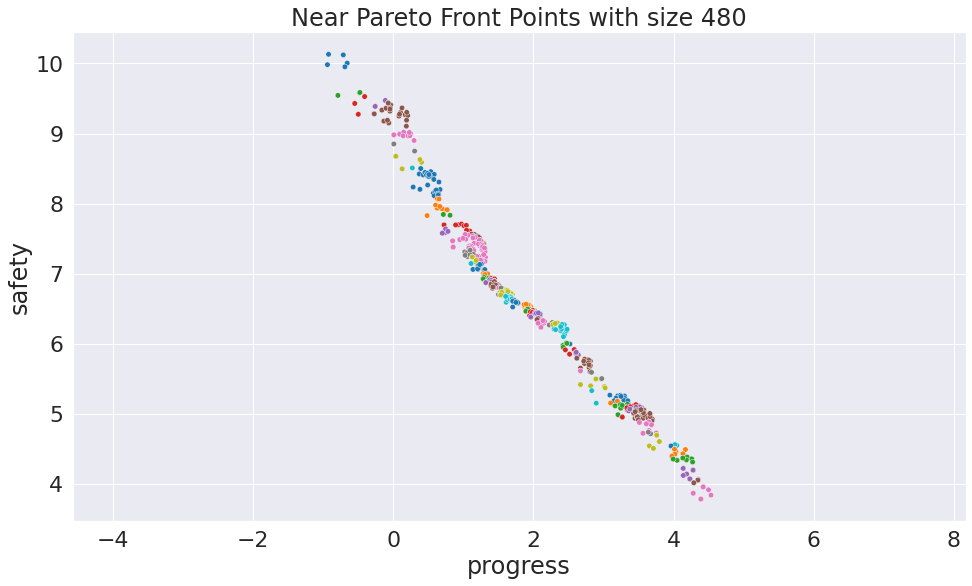

In [156]:
dist_thres = 0.2
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    # tmp = np.nonzero(dist<dist_thres)[0];
    if   i < objective_score.shape[1] *2 / 3 and i > objective_score.shape[1] / 4:
        tmp = np.nonzero(dist<dist_thres/2)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres)[0];
    else:
        tmp = np.nonzero(dist<dist_thres*1.5)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

# DPP

In [157]:
from argparse import Namespace
from scipy.spatial.distance import pdist, squareform
from dppy.finite_dpps import FiniteDPP
args = {}
args["near_pareto_path"] = f'../data/{run}/near_pareto_idx.npz'
args["data_path"] = os.path.join(data_module, score_file)
args["sample_num"] = 20
args["seed"] = 6300
args = Namespace(**args)

In [158]:
# dpp


# seeding
rng = np.random.RandomState(args.seed)
np.random.seed(args.seed)

near_pareto = np.load(args.near_pareto_path)
data = np.load(args.data_path)

near_pareto_idx = near_pareto["near_idx"]
obj = data["scores"]
cost_weights = data["params"]
near_pareto_obj = obj[near_pareto_idx]

# likelihood kernel
l = 1
mcmc_iter = 30
L = np.exp(-(1 / (2 * (l**2))) * squareform(pdist(near_pareto_obj, "sqeuclidean")))
# k-DPP
DPP = FiniteDPP("likelihood", **{"L": L})
# sample
DPP.flush_samples()
for mcmc_iter in range(mcmc_iter):
    DPP.sample_exact_k_dpp(size=args.sample_num, random_state=rng)

final_sample_idx = DPP.list_of_samples[-1]
final_samples = obj[near_pareto_idx[final_sample_idx]]
print("Final sample indices", near_pareto_idx[final_sample_idx])

Final sample indices [10628  5758   822   646  5729  2061  3975  5688  8806  7786  7649  9228
   874   981  1441   794  5427  4887   189  3868]


In [183]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


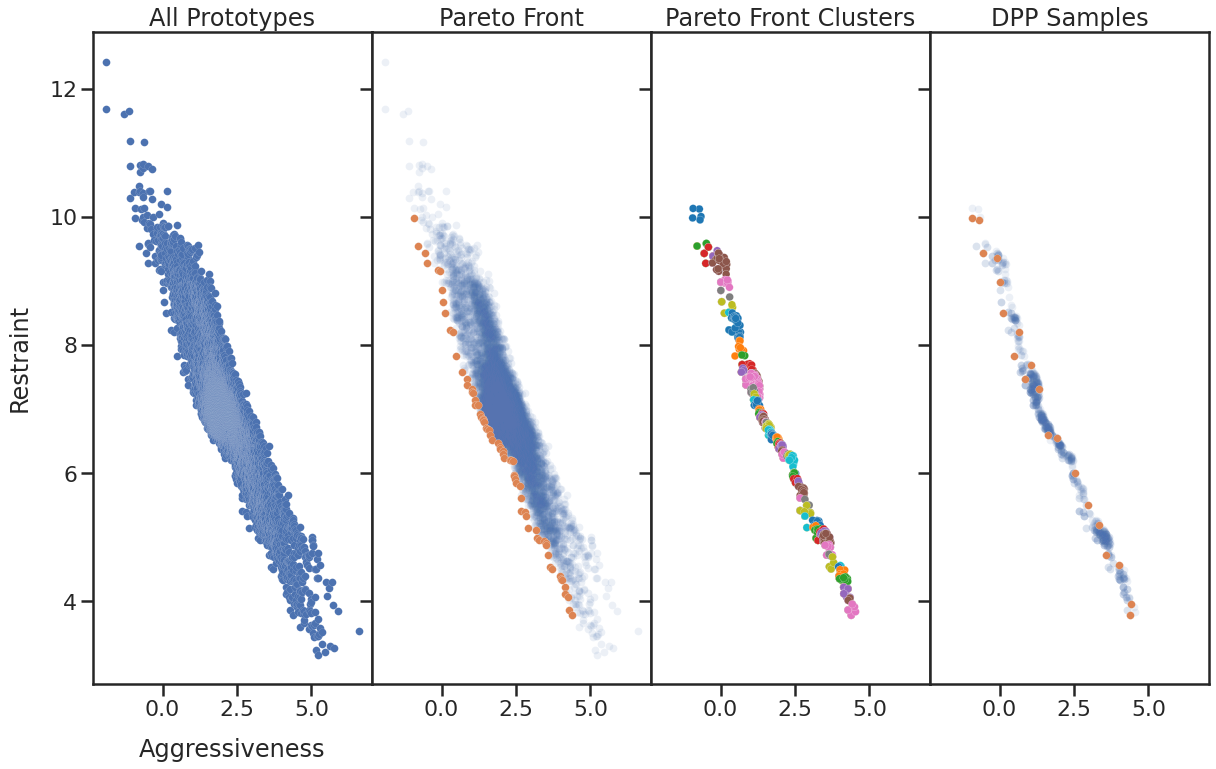

In [192]:
# https://blog.csdn.net/HLBoy_happy/article/details/77581802
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (20, 12)

fig = plt.figure()

gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)


sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=60, ax=ax[0],linewidth=0.1)
ax[0].set_ylabel('Restraint', labelpad=18)
ax[0].set_xlabel('Aggressiveness', labelpad=18)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', alpha=0.1, s=60, ax=ax[1],linewidth=0.1)
# sns.scatterplot(data=data_df_pf, x='progress', y='safety', label='Pareto front', s=60, palette='tab10', ax=ax[1])
sns.scatterplot(data=data_df_pf, x='progress', y='safety', s=60, palette='tab10', ax=ax[1],linewidth=0.2)
# plt.legend(loc=2, prop={'size': 6})
ax[1].set_xlabel('', labelpad=None)
ax[1].set_title('Pareto Front')
# ax[1].set_yticks([]) 
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id',linewidth=0.2, legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Pareto Front Clusters')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=cluster_df, x='progress', y='safety', legend=False, s=60, alpha=0.1, ax=ax[3],linewidth=0.1)
# sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, label='DPP samples',  ax=ax[3])
sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, ax=ax[3],linewidth=0.2)
ax[3].set_xlabel('', labelpad=None)
ax[3].set_title('DPP Samples')

# fig.title('title', y=-0.2)
plt.margins(0,0)
plt.savefig('pf_glob_4.eps', format='eps')
plt.savefig('pf_glob_4.png', format='png')

plt.show()

/home/zzjun/Documents/objective_space/obj_space_planning/es_src/data/31/near_pareto_idx.npz
near pareto front dist threshold is 0.4, near pareto front point number is 1289


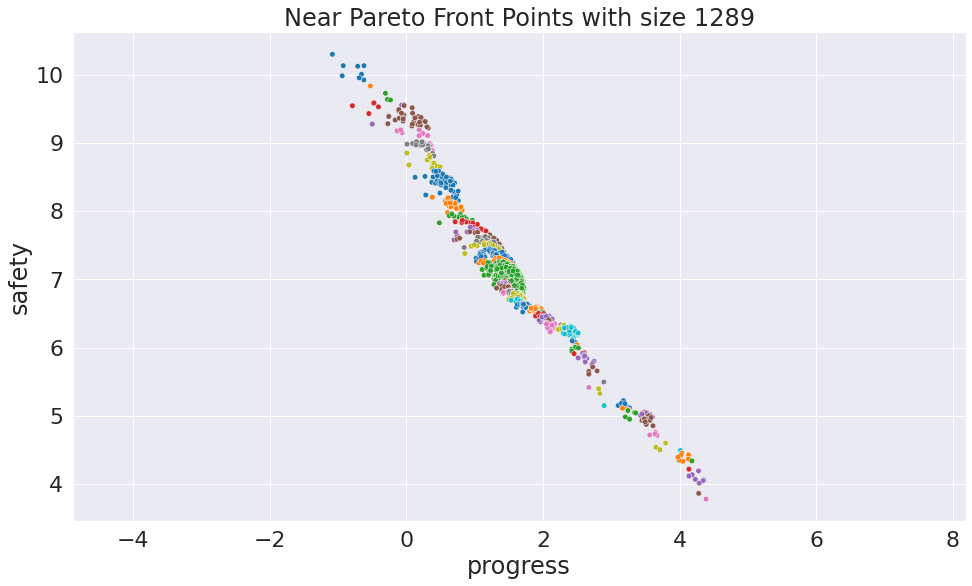

In [151]:
dist_thres = 0.4
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    if i > objective_score.shape[1]  / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    else:
        tmp = np.nonzero(dist<dist_thres)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

In [152]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

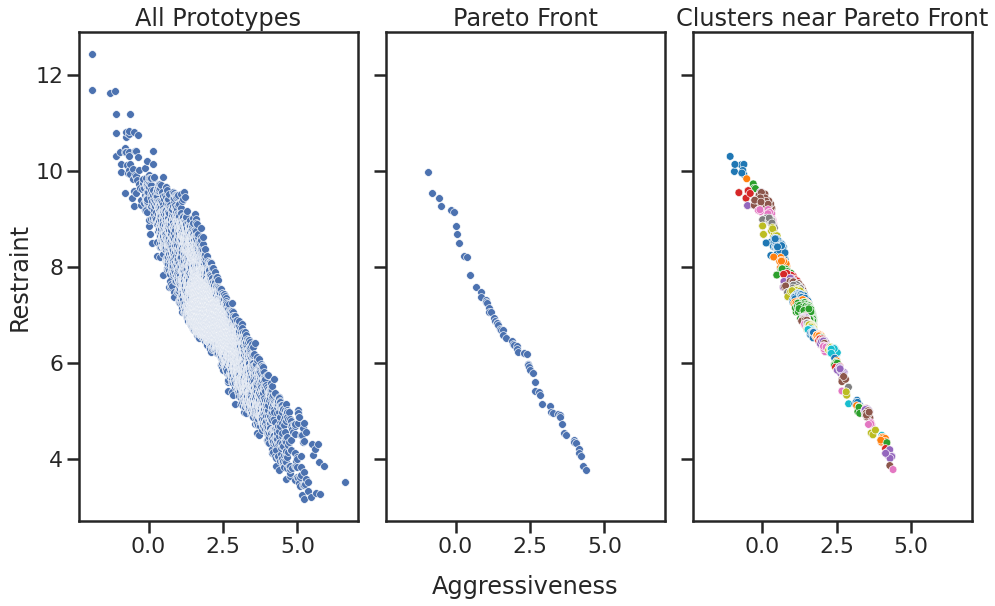

In [153]:
fig = plt.figure()
gs = fig.add_gridspec(1, 3, hspace=0, wspace=0.1)
ax = gs.subplots(sharex=True, sharey=True)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=60, ax=ax[0])
ax[0].set_ylabel('Restraint', labelpad=None)
ax[0].set_xlabel('', labelpad=20)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df_pf, x='progress', y='safety', legend='brief', s=60, palette='tab10', ax=ax[1])
ax[1].set_xlabel('Aggressiveness', labelpad=18)
ax[1].set_title('Pareto Front')
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Clusters near Pareto Front')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


plt.show()

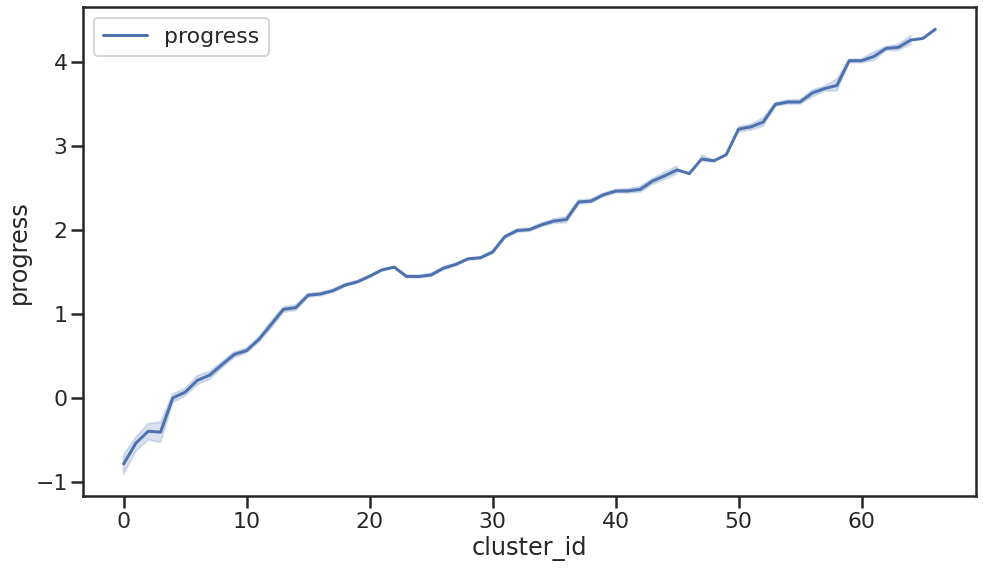

In [154]:
# print(cluster_df.head())
# for i in near_dict.keys():
sns.lineplot(data=cluster_df, x='cluster_id', y='progress', label='progress')
# sns.lineplot(data=cluster_df, x='cluster_id', y='safety', label='safety')
plt.legend()
plt.show()

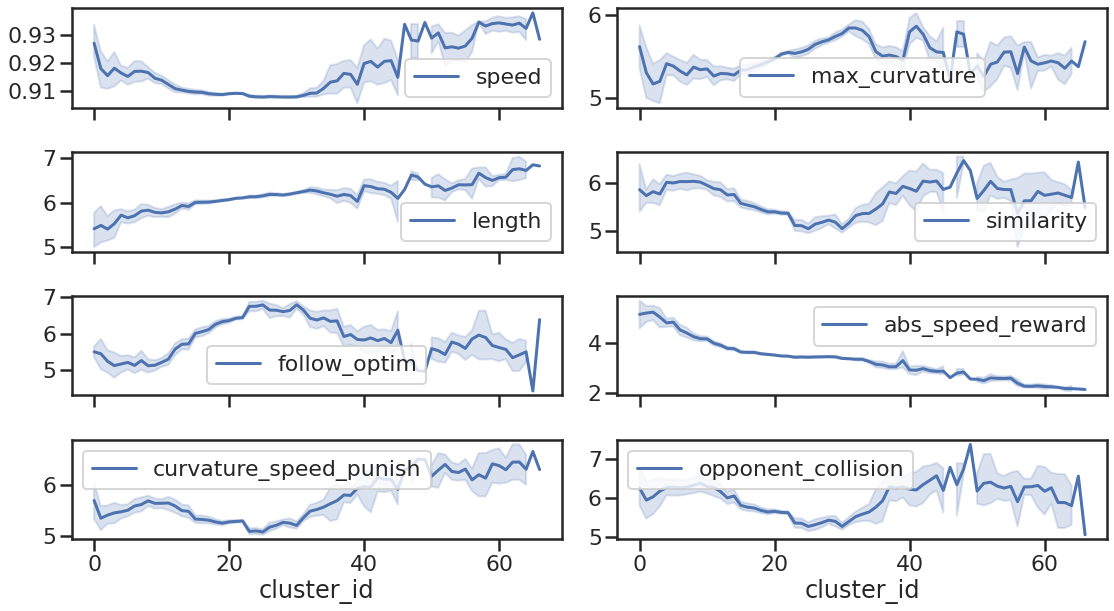

In [155]:
rows = (len(param_dict.keys()) + 1) // 2
fig, axes = plt.subplots(rows, 2, squeeze=False, sharex=True)
for i, param in enumerate(param_dict.values()):
    sns.lineplot(data=cluster_df, x='cluster_id', y=param, ax=axes[i//2][i%2], label=param)
    axes[i//2][i%2].set_ylabel('')
# sns.lineplot(data=cluster_df, x='cluster_id', y='collision thres', ax=axes[0][1])
# sns.lineplot(data=cluster_df, x='cluster_id', y='speed')
# plt.xlabel('iter_step', fontsize=font_size)

# plt.title('crash and overtake rollout number over Iteration', fontsize=font_size)
plt.tight_layout()
# plt.legend()
plt.show()


In [35]:
# sns.scatterplot(data=data_df, x='PC_1', y='PC_2', hue='safety', s=100)
# # plt.legend(title='distance', fontsize=font_size)
# plt.xlabel('PC_1', fontsize=font_size)
# plt.ylabel('PC_2', fontsize=font_size)
# plt.title(f'Pareto front PCA of safety', fontsize=font_size)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
# plt.show()

# Get more point near Pareto Front

In [36]:
# seeds_w_score_df
print(all_scores.shape)
print(all_seeds.shape)
print(pareto_arr.shape)
print(objective_score.shape)

(2, 12100)
(8, 12100)
(8, 48)
(2, 48)


In [37]:
# objective_score = objective_score[:, :30]

In [ ]:
dist_thres = 0.3
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    # tmp = np.nonzero(dist<dist_thres)[0];
    if i > objective_score.shape[1]  / 3:
        tmp = np.nonzero(dist<dist_thres/4)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres/4)[0];
    else:
        tmp = np.nonzero(dist<dist_thres)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

# DPP

In [ ]:
from argparse import Namespace
from scipy.spatial.distance import pdist, squareform
from dppy.finite_dpps import FiniteDPP
args = {}
args["near_pareto_path"] = f'../es_model/{run}/near_pareto_idx.npz'
args["data_path"] = os.path.join(data_module, score_file)
args["sample_num"] = 20
args["seed"] = 6300
args = Namespace(**args)

In [ ]:
# dpp


# seeding
rng = np.random.RandomState(args.seed)
np.random.seed(args.seed)

near_pareto = np.load(args.near_pareto_path)
data = np.load(args.data_path)

near_pareto_idx = near_pareto["near_idx"]
obj = data["scores"]
cost_weights = data["params"]
near_pareto_obj = obj[near_pareto_idx]

# likelihood kernel
l = 1
mcmc_iter = 30
L = np.exp(-(1 / (2 * (l**2))) * squareform(pdist(near_pareto_obj, "sqeuclidean")))
# k-DPP
DPP = FiniteDPP("likelihood", **{"L": L})
# sample
DPP.flush_samples()
for mcmc_iter in range(mcmc_iter):
    DPP.sample_exact_k_dpp(size=args.sample_num, random_state=rng)

final_sample_idx = DPP.list_of_samples[-1]
final_samples = obj[near_pareto_idx[final_sample_idx]]
print("Final sample indices", near_pareto_idx[final_sample_idx])

In [ ]:

near_pareto_obj

In [ ]:
# https://blog.csdn.net/HLBoy_happy/article/details/77581802
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

fig = plt.figure()
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=60, ax=ax[0])
ax[0].set_ylabel('Restraint', labelpad=18)
ax[0].set_xlabel('Aggressiveness', labelpad=18)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', alpha=0.1, s=60, ax=ax[1])
# sns.scatterplot(data=data_df_pf, x='progress', y='safety', label='Pareto front', s=60, palette='tab10', ax=ax[1])
sns.scatterplot(data=data_df_pf, x='progress', y='safety', s=60, palette='tab10', ax=ax[1])
# plt.legend(loc=2, prop={'size': 6})
ax[1].set_xlabel('', labelpad=None)
ax[1].set_title('Pareto Front')
# ax[1].set_yticks([]) 
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Pareto Front Clusters')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=cluster_df, x='progress', y='safety', legend=False, s=60, alpha=0.1, ax=ax[3])
# sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, label='DPP samples',  ax=ax[3])
sns.scatterplot(x=final_samples[:, 0], y=final_samples[:, 1], s=60, ax=ax[3])
ax[3].set_xlabel('', labelpad=None)
ax[3].set_title('DPP Samples')

# fig.title('title', y=-0.2)
plt.savefig('pf_glob_4.pdf', format='pdf')

plt.show()

/home/zzjun/Documents/objective_space/obj_space_planning/es_src/data/27/near_pareto_idx.npz
near pareto front dist threshold is 0.4, near pareto front point number is 365


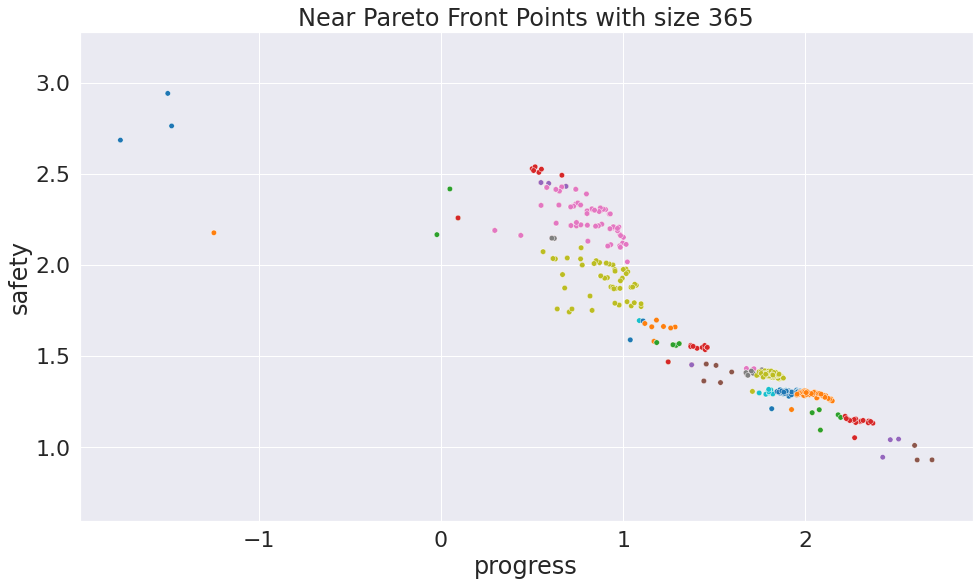

In [254]:
dist_thres = 0.4
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    if i > objective_score.shape[1]  / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    elif i > objective_score.shape[1] *2 / 3:
        tmp = np.nonzero(dist<dist_thres/3)[0];
    else:
        tmp = np.nonzero(dist<dist_thres)[0];
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)

unique_near_idx_set = set()
unique_near_idx = []
for idx in near_idx:
    if idx not in unique_near_idx_set:
        unique_near_idx_set.add(idx)
        unique_near_idx.append(idx)
near_idx = np.array(unique_near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=unique_near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
# near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=30, palette="tab10")
# label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress')
plt.ylabel('safety')
plt.title(f'Near Pareto Front Points with size {len(near_pareto_seeds)}')
# plt.legend(bbox_to_anchor=(0.5, -0.5),loc=8,ncol=8)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
plt.axis('equal')
plt.show()

In [255]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"] = (16, 9)

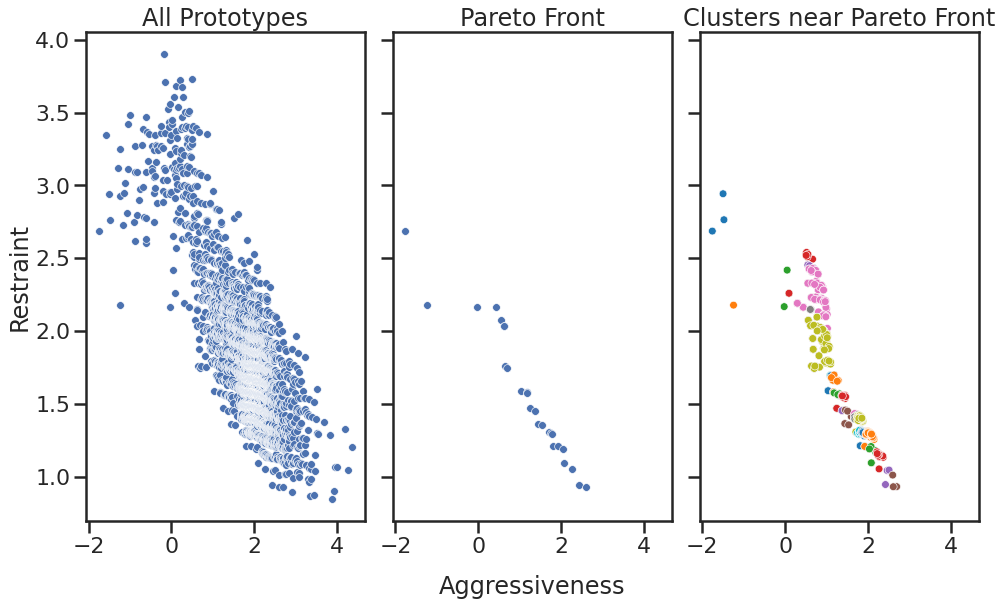

In [256]:
fig = plt.figure()
gs = fig.add_gridspec(1, 3, hspace=0, wspace=0.1)
ax = gs.subplots(sharex=True, sharey=True)

sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=60, ax=ax[0])
ax[0].set_ylabel('Restraint', labelpad=None)
ax[0].set_xlabel('', labelpad=20)
ax[0].set_title('All Prototypes')
# ax[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

sns.scatterplot(data=data_df_pf, x='progress', y='safety', legend='brief', s=60, palette='tab10', ax=ax[1])
ax[1].set_xlabel('Aggressiveness', labelpad=18)
ax[1].set_title('Pareto Front')
# ax[1][0].set_ylabel('Manuver Rates')
# ax[1][0].set_title('Crash and Overtake Rates')
# ax[1][0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend=False, s=60, palette="tab10", ax=ax[2])
ax[2].set_xlabel('', labelpad=None)
ax[2].set_title('Clusters near Pareto Front')
# ax[0][1].set_ylabel('Objective Scores', labelpad=25)
# ax[0][0].set_title('Objectives Scores')
# ax[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)


plt.show()

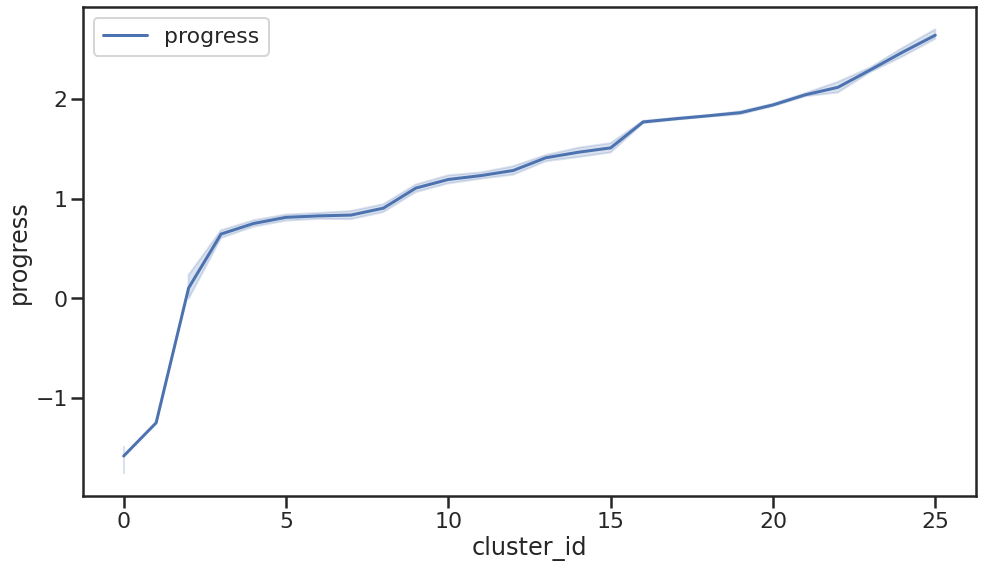

In [257]:
# print(cluster_df.head())
# for i in near_dict.keys():
sns.lineplot(data=cluster_df, x='cluster_id', y='progress', label='progress')
# sns.lineplot(data=cluster_df, x='cluster_id', y='safety', label='safety')
plt.legend()
plt.show()

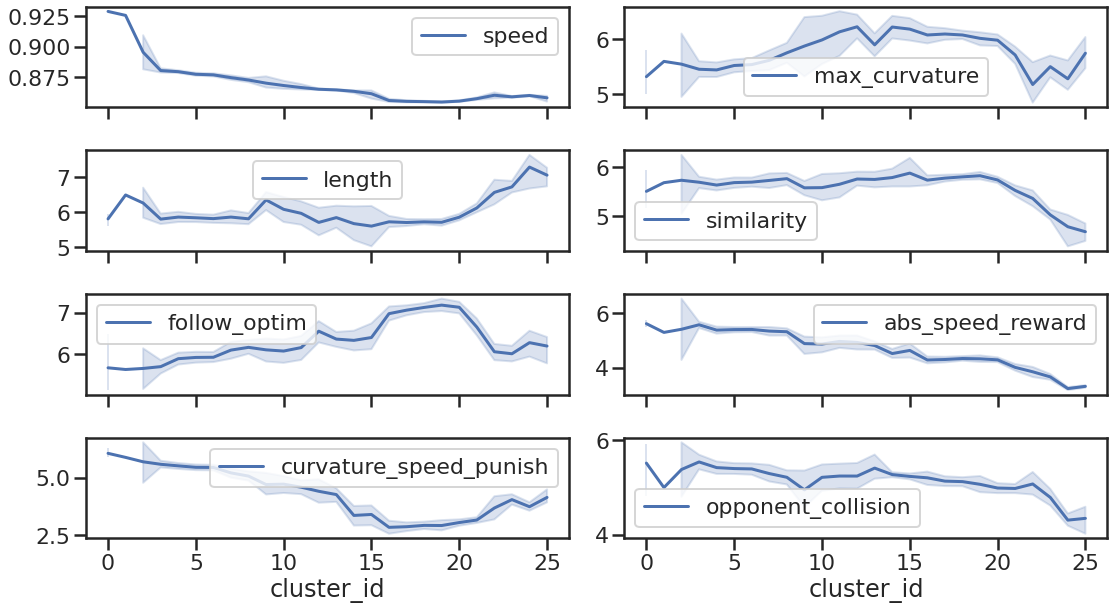

In [213]:
rows = (len(param_dict.keys()) + 1) // 2
fig, axes = plt.subplots(rows, 2, squeeze=False, sharex=True)
for i, param in enumerate(param_dict.values()):
    sns.lineplot(data=cluster_df, x='cluster_id', y=param, ax=axes[i//2][i%2], label=param)
    axes[i//2][i%2].set_ylabel('')
# sns.lineplot(data=cluster_df, x='cluster_id', y='collision thres', ax=axes[0][1])
# sns.lineplot(data=cluster_df, x='cluster_id', y='speed')
# plt.xlabel('iter_step', fontsize=font_size)

# plt.title('crash and overtake rollout number over Iteration', fontsize=font_size)
plt.tight_layout()
# plt.legend()
plt.show()
